---
category: 数学
tag: 
  - 数学
---

# 生成任意分布的随机数

一般的编程语言或库都有生成均匀分布的（伪）随机数的函数。但有时我们会需要生成一个具有指定分布函数的随机数。这就需要我们对均匀分布的随机数进行变换。

比如我们可能会经常遇到的，生成一个均匀分布于二维平面单位圆内的随机点。通常做法可以是生成 $x, y \sim U(-1, 1)$，然后判断是否在单位圆内，如果不在则重新取。

## 圆内均匀分布的简单实现

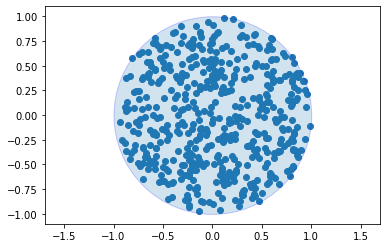

In [ ]:
import random
from typing import Tuple, List
from matplotlib import pyplot as plt

Point = Tuple[float, float]

def random_point_in_unit_circle_trivial() -> Point:
    while True:
        x = 2.0 * random.random() - 1.0
        y = 2.0 * random.random() - 1.0
        if x ** 2 + y ** 2 < 1:
            return x, y

# https://stackoverflow.com/questions/9081553/python-scatter-plot-size-and-style-of-the-marker/24567352#24567352
# https://stackoverflow.com/a/24568380/4635234
def draw_circle(center: Point, radius: float, **kwargs):
    import matplotlib.patches
    import matplotlib.collections
    patches = [matplotlib.patches.Circle(center, radius)]
    collection = matplotlib.collections.PatchCollection(patches, **kwargs)

    ax = plt.gca()
    ax.add_collection(collection)
    ax.autoscale_view()
    ax.axis('equal')

def draw_points(points: List[Point]):
    x, y = zip(*points)
    plt.scatter(x, y)

points = [random_point_in_unit_circle_trivial() for _ in range(500)]
draw_points(points)
draw_circle((0, 0), 1, alpha=0.2, edgecolor='b')



这当然是一个方法，但它局限于均匀分布。而且重复随机采样，虽然平均复杂度仍为 $O(1)$，但是似乎不太优雅。有没有一种更通用的方法呢？



## 基于分布函数的方法

还是同样的问题。我们可以看出，在单位圆内均匀分布的点，用笛卡尔坐标表示为 $(X, Y)$，满足如下分布函数：
$$
f_{XY}(x, y) = \left\{
\begin{aligned}
&\frac{1}{\pi}, & x^2 + y^2 < 1 \\
&0, & \text{otherwise}
\end{aligned}
\right.
$$
这看起来并不是一个非常简单的分布函数。我们不妨用极坐标表示为 $(\Rho, \Theta)$。（其中 $\Rho, \Theta$ 为随机变量，是 $\rho$ 和 $\theta$ 的大写。）这样有
$$
g_{\Rho\Theta}(\rho, \theta) = \left\{
\begin{aligned}
&\frac{\rho}{\pi}, & \rho < 1 \\
&0, & \text{otherwise}
\end{aligned}
\right.
$$
（以下将两个分布函数简写为 $f$、$g$。）

这个分布函数是如何得到的呢？这就是多元微积分的知识了。实际上我们可以先验证一下这个分布函数是否正确，至少它应满足积分为$1$。
$$
\int_0^{2\pi}d\theta \int_0^1 g(\rho, \theta) d\rho = 1
$$
确实没错。

教材上会告诉我们，要计算 Jacobi 矩阵的行列式，然后可能会给出一堆证明，令人头秃。实际上，我们可以通过极坐标和笛卡尔坐标的微分转换关系，用一个比较形象的方法得到上述分布函数。

<img src="imgs/cartesian_polar.png" width=400px />

在单位圆内取一个微小的区域 $d\Omega$。无论用何种坐标系，点落在这个微小区域内的概率应该是一样的，即
$$
p_{d\Omega} = P(x < X < x + dx, y < Y < y + dy) = P(\rho < \Rho < \rho + d\rho, \theta < \Theta < \theta + d\theta)
$$
用分布函数的积分值表示上述点落在这个区域内的概率，即
$$
f(x, y)dxdy = g(\rho, \theta) d\rho d\theta
$$
而根据微分的转换关系，有
$$
dxdy = \rho d\rho d\theta
$$
这可以由 Jacobi 矩阵的行列式得到，也可以用上图来看出。$dx dy$ 是用直角坐标系计算 $d\Omega$ 的面积，而 $\rho d\rho d\theta$ 是用极坐标系计算 $d\Omega$ 的面积，其中 $d\rho$ 是沿极坐标径向的长度，$\rho d\theta$ 是垂直于径向的弧长。注意这只是形象的解释，具体计算原则还是应该按照教科书上的推导。

所以有
$$
g(\rho, \theta) = f(x, y) \rho = \frac{\rho}{\pi}, \quad 0 < \rho < 1
$$

那么可以看出 $\rho$ 和 $\theta$ 的分布函数相互独立，即
$$
g_{\Rho\Theta}(\rho, \theta) = h_{\Rho}(\rho)\cdot t_{\Theta}(\theta) = 2\rho \cdot \frac{1}{2\pi} 
$$
我们只需要生成一个 $[0, 2\pi)$ 均匀分布的 $\theta$，和一个在 $[0, 1)$ 上、分布函数为 $h(\rho) = 2\rho$ 的 $\rho$ 即可。

接下来问题就是如何生成分布函数为 $h(\rho) = 2\rho, \rho \in [0, 1)$ 的随机变量了。

## 生成服从某分布函数的随机变量

考虑服从以下分布函数的随机变量 $\Rho$：
$$
f_\Rho(\rho)=2\rho, \quad \rho \in [0, 1)
$$
我们在程序中可以直接随机生成的随机数 $Z$ 一般是服从 $U(0, 1)$ 的。即分布函数为
$$
f_Z(z) = 1, \quad z \in [0, 1)
$$

现在我们希望建立 $\Rho$、$Z$ 之间的函数关系，这样我们就可以通过一个变换，从随机生成的 $Z$ 得到 $\Rho$。这个函数关系我们还不知道。那么我们仍然可以用两个分布函数分别表示随机数落在某一微小区间内的概率：
$$
p_{d\Omega} = P(\rho < \Rho < \rho + d\rho) = P(z < Z < z + dz)
$$
用分布函数的微分表示：
$$
f_\Rho(\rho)d\rho = f_Z(z)dz
$$
那么
$$
\frac{dz}{d\rho} = \frac{f_\Rho(\rho)}{f_Z(z)} = 2\rho
$$
神奇了，我们得到了 $z$ 关于 $\rho$ 的导数。那么对其积分，可得
$$
z = \rho^2 + C
$$
根据 $z$ 和 $\rho$ 的定义域，我们可以约定 $z=0$ 时 $\rho = 0$，那么 $C = 0$，于是
$$
z = \rho^2
$$
即
$$
\rho = \sqrt{z}
$$

也就是说，我们生成一个 $Z \sim U(0, 1)$，然后求根号，就得到了服从分布函数 $f_\Rho$ 的 $\Rho$ 了。

我们试试用这个方法生成单位圆内均匀分布的点。

In [ ]:
import math

def random_point_in_unit_circle() -> Point:
    while True:
        rho = math.sqrt(random.random())
        theta = 2 * math.pi * random.random()
        return rho * math.cos(theta), rho * math.sin(theta)

points = [random_point_in_unit_circle() for _ in range(500)]
draw_points(points)
draw_circle((0, 0), 1, alpha=0.2, edgecolor='b')